## Using MERFISH Tools for downstream analysis of MERSCOPE data

After performing a MERFISH experiment on the MERSCOPE and on-device data processing has completed, there will be 3 folders relevant to your experiment:

* The raw images
* The output of the MERlin software
* The organized results folder

This last folder is all that is required for most downstream analysis, however the other two can be useful for certain QC metrics and specialized analyses. The first step to analyzing the data is to load the cell by gene table of detected molecules per cell into a scanpy object along with the spatial information. The :class:`MerfishAnalysis` class provides an interface to load this information from the results folder. If your experiment contained multiple regions, there are seperate tables for cell metadata, cell by gene, etc. for each region, however this class will automatically combine these into single tables with the original region added as a column.

In [1]:
from mftools.fileio import MerfishAnalysis

output = MerfishAnalysis("/storage/RNA_MERFISH/MERSCOPE/Vizgen_Output/202109211558_20210921M004MTGS3_Beta10") 

/home/jckern/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can now pass this MerfishAnalysis object to the :func:`create_scanpy_object` function from the mftools.cellgene module to create the scanpy object.

In [2]:
from mftools.cellgene import create_scanpy_object

adata = create_scanpy_object(output)

The resulting adata object contains the following data:

adata.X: The raw transcript count matrix

adata.obs: This contains the columns n_genes_by_counts, log1p_n_genes_by_counts, total_counts, log1p_total_counts as added by sc.pp.calculate_qc_metrics. Additionally, it contains
  * volume: The volume of the cell
  * fov: The field of view the cell is in
  * blank_counts: The number of blank barcodes decoded in this cell
  * misid_rate: The misidentification rate calculated for this cell
  * counts_per_volume: The transcript density of the cell

adata.var: This contains the n_cells_by_counts, mean_counts, log1p_mean_counts, pct_dropout_by_counts, total_counts, log1p_total_counts columns as added by sc.pp.calculate_qc_metrics.

adata.obsm:
  * X_blanks: The matrix of blank barcode counts per cell
  * X_spatial: The spatial coordinates of the cells

adata.uns:
  * blank_names: The name of the blank barcode corresponding to each column of adata.obsm["X_blanks"]
  * dataset_name: The name of this dataset

adata.layers:
  * counts: A copy of the raw transcript count matrix which will remain after normalization, scaling, etc.

We can use the sc.pl.embedding function to plot the spatial positions of the cells:

/home/jckern/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


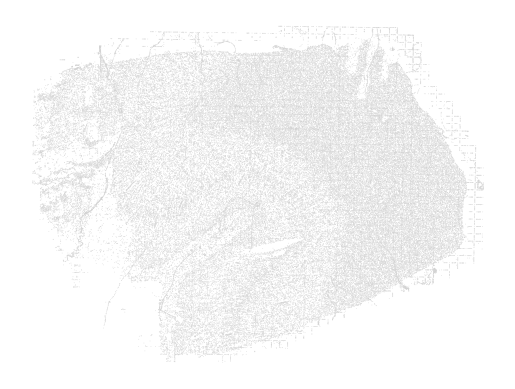

In [5]:
import scanpy as sc

sc.pl.embedding(adata, basis="spatial", frameon=False)

As we can see, the MERSCOPE segmentation method produces some artifacts. These are generally filtered during standard filtering steps that remove cells with low transcript counts.

In [6]:
import scanpy as sc
sc.settings.verbosity = 3
sc.pp.filter_cells(adata, min_genes=5)
sc.pp.filter_genes(adata, min_cells=1)

filtered out 37009 cells that have less than 5 genes expressed


/home/jckern/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


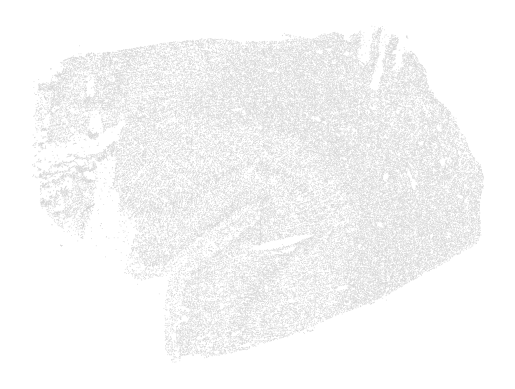

In [7]:
sc.pl.embedding(adata, basis="spatial", frameon=False)

We can start looking at the expression of some genes. To avoid an outlier cell with very high detected transcripts of a gene affecting the color scale, it can be helpful to set the maximum value of the scale to the 99th or 99.9th percentile.

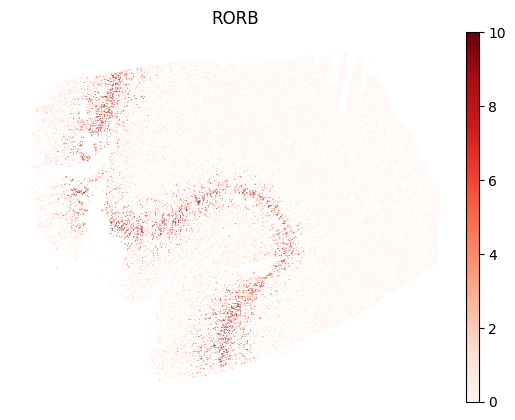

In [9]:
import scanpy as sc
sc.pl.embedding(adata, basis="spatial", color="RORB", cmap="Reds", vmax="p99", frameon=False)

For cell clustering, standard workflows for scRNA-seq are suitable. Because MERFISH experiments only measure a limited number of genes, filtering of highly variable genes is often skipped. For the same reason, it is not required to use PCA for feature reduction.

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata, base=2)

normalizing counts per cell
    finished (0:00:00)


In [11]:
# Option 1: Without PCA
sc.pp.neighbors(adata, use_rep="X", n_neighbors=30, metric="cosine")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:37)


In [ ]:
# Option 2: Using PCA
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30)

In [12]:
sc.tl.leiden(adata) 
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos="paga", min_dist=0.3, spread=1)

running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:42)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:03)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:07)


In [61]:
sc.tl.leiden(adata, resolution=2)

running Leiden clustering
    finished: found 95 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:23)


/home/jckern/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


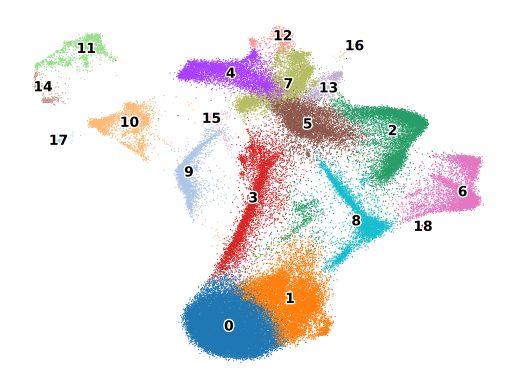

In [14]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", legend_fontoutline=2, s=3, frameon=False, title="")

Once the clustering is completed, the next step is usually to characterize these clusters and give them biologically meaningful names. If another dataset (scRNA-seq, MERFISH, or any other single cell assay) is available with cell types already labeled, MERFISH Tools provides the :func:`label_clusters` function to name the clusters based on this other dataset. Scanpy also provides an ingest function that can transfer labels from one dataset to another, but this is done on a cell by cell basis.

In [15]:
refdata = sc.read("/storage/RNA_MERFISH/Reference_Data/BA9/raw_subset.h5ad")

In [16]:
sc.pp.normalize_total(refdata)
sc.pp.log1p(refdata, base=2)

normalizing counts per cell
    finished (0:00:00)


In [17]:
from mftools.cellgene import label_clusters

adata.obs["label"] = label_clusters(adata, refdata, "leiden", "final_subclass")

/home/jckern/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


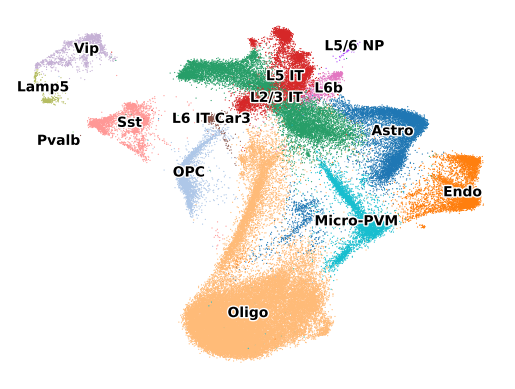

/home/jckern/.local/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


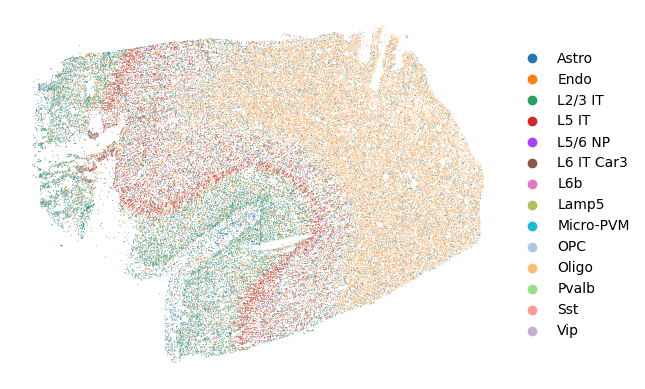

In [19]:
sc.pl.umap(adata, color="label", legend_loc="on data", legend_fontoutline=2, s=3, frameon=False, title="")
sc.pl.embedding(adata, basis="spatial", color="label", frameon=False, title="")